# Example Workflow
In this notebook we'll go through an example workflow of analysis, by applying it to example data.

For a more in depth tutorial see [FISSA Tutorial](FISSA Tutorial.ipynb). 

These are still toy examples and should not be seen as 

### Imports

In [1]:
# General imports
from __future__ import division
import numpy as np
from PIL import Image
import time
import glob
import os
import pickle

# Plotting toolbox
import holoviews as hv
%load_ext holoviews.ipython

# FISSA toolbox imports
import fissa.roitools as ROI
import fissa.readtiffs as rtp
import fissa.neuropil as npil
import fissa.deltaf as df

### Basic settings

In [2]:
# Define folder where tiffs are present
folder = '../exampleData/20150529_mini/'

# Load tiffs in folder
tiffs  = sorted(glob.glob(folder+'/*.tif')) # gets the names of all the tif files in the folder, ordered by filename

# define ROI sets in zips per tiff
ROIs = ['../exampleData/RoiSet0529miniTrial1.zip','../exampleData/RoiSet0529miniTrial23.zip','../exampleData/RoiSet0529miniTrial23.zip']

# set neuropil settings
iterations = 15 # number of iterations/distance in pixels of neuropil. 
                # This determines the width of the neuropil. 
                # The larger this number, the larger the neuropil region surrounding a somatic ROI is.
nNpil      = 8  # number of neuropil slices
                # The larger this number, the more neuropil signals will be extracted. 
                # Make this larger if there's a lot of signals in your recordings, 
                # i.e. a lot of bunched up cells/axons/dendrites/etc.
sep_method = 'nmf' # separation method
n          = nNpil  # number of output signals. If None, will be estimated from explained variance through PCA.

### Data setup
Note that in the below example, if your rois are the same for every tiff, you can take the mask generation out of the loop.

We also generally assume that in one set of tiffs, the same cells are present.

In [3]:
# find number of cells (needs to be same in every roi set in ROIs!)
l    = ROIs[0]
rois = ROI.readrois(l)
nRois = len(rois)-1 # -1 for now as one roi is not used

# setup data structures where data will be stored
S = {} # for traces and ROI outlines
S['Data'] = {} # where traces will be stored
S['ROIs'] = {} # where ROI outlines will be stored
# gener
for m in range(nRois):
    S['Data'][m] = {}
    S['ROIs'][m] = {}

# loop over the masks
for i,l in enumerate(ROIs):
    # load tiff
    img = Image.open(tiffs[i]) # pillow loaded reference image
    shpe = img.size[::-1]
    
    # load in basic rois
    rois = ROI.readrois(l)
    
    # calculate masks (can take a while)
    soma_masks = ROI.getmasks(rois,shpe)
    
    # for each soma mask, calculate the surrounding neuropil rois
    Masks = {} # where to store the masks
    Mask_outlines = {} # where to store mask outlines
    
    for m,mask in enumerate(soma_masks[1:]): # loop over masks (skipping the first)
        # get neuropil masks
        npil_masks = ROI.getmasks_npil(mask,nNpil=nNpil,iterations=iterations)
        
        # store the masks
        Masks[m] = [mask]
        Masks[m]+= npil_masks

        # calculate the outlines
        Mask_outlines[m] = {}
        for j in range(len(Masks[m])):
            # calculate outline
            outline = ROI.find_roi_edge(Masks[m][j])
            
            # store the outline coordinates
            Mask_outlines[m][j] = outline
    
    # extract traces
    data = rtp.extract_from_single_tiff(tiffs[i],Masks)
    
    # loop over rois again
    for m in range(nRois):        
        # store traces
        S['Data'][m][i]  = data[m]
    
        # store mask outlines
        S['ROIs'][m][i] = Mask_outlines[m]

/home/swk/Code/rochefort-lab/fissa/fissa/sima_borrowed/ROI.py:145: UserWarning: Polygon initialized without z-coordinate. Assigning to zeroth plane (z = 0)
  'Assigning to zeroth plane (z = 0)')


### Apply separation method (ICA or NMF)

In [10]:
%%timeit
# add space to dictionary for  and matched signals and mixing matrix
S['Sep'] = {} # separated
S['Mat'] = {} # matched
S['Mix'] = {} # mixing matrix
S['Con'] = {} # convergenge info
for m in range(nRois):
    S['Sep'][m] = {}
    S['Mat'][m] = {}
    
# separate the signals to estimate baseline signal
for m in range(nRois): # loop over all ROIs
    # stick all tiffs together
    data = S['Data'][m][0] # initiation
    for i in range(1,len(S['Data'][m])): # loop over all tiffs
        data = np.concatenate((data,S['Data'][m][i]),axis=1)

    # and separate
    S_sep,S_matched,A_sep,convergence = npil.separate(data,sep_method='nmf',n=n)

    # Fill in dictionary with relevant info
    S['Mix'][m] = A_sep
    S['Con'][m] = convergence
    # Fill in dictionary with separated and matched signals
    totlen = 0 # total length gone through
    for i in range(len(S['Data'][m])): # loop over all tiffs
        # get length of current trial
        l = len(S['Data'][m][i][0,:])
    
        # copy over that amount of data
        S['Sep'][m][i] = S_sep[:,totlen:totlen+l]
        S['Mat'][m][i] = S_matched[:,totlen:totlen+l]
        
        # update totlen
        totlen += l
        

NMF converged after 361 iterations.
NMF converged after 333 iterations.
NMF converged after 436 iterations.
NMF converged after 434 iterations.
NMF converged after 374 iterations.
1 loop, best of 3: 945 ms per loop


:Layout
   .Overlay.I   :Overlay
      .Scatter.I    :Scatter   [x]   (y)
      .Scatter.II   :Scatter   [x]   (y)
      .Scatter.III  :Scatter   [x]   (y)
      .Scatter.IV   :Scatter   [x]   (y)
      .Scatter.V    :Scatter   [x]   (y)
      .Scatter.VI   :Scatter   [x]   (y)
      .Scatter.VII  :Scatter   [x]   (y)
      .Scatter.VIII :Scatter   [x]   (y)
      .Scatter.IX   :Scatter   [x]   (y)
   .Overlay.II  :Overlay
      .Curve.I    :Curve   [Time (s)]   (Signal)
      .Curve.II   :Curve   [Time (s)]   (Signal)
      .Curve.III  :Curve   [Time (s)]   (Signal)
      .Curve.IV   :Curve   [Time (s)]   (Signal)
      .Curve.V    :Curve   [Time (s)]   (Signal)
      .Curve.VI   :Curve   [Time (s)]   (Signal)
      .Curve.VII  :Curve   [Time (s)]   (Signal)
      .Curve.VIII :Curve   [Time (s)]   (Signal)
      .Curve.IX   :Curve   [Time (s)]   (Signal)
   .Overlay.III :Overlay
      .Curve.Rank_0 :Curve   [Time (s)]   (Signal)
      .Curve.Rank_1 :Curve   [Time (s)]   (Signal)
      .Curve.Rank_2 :Curve   [Time (s)]   (Signal)
      .Curve.Rank_3 :Curve   [Time (s)]   (Signal)
      .Curve.Rank_4 :Curve   [Time (s)]   (Signal)
      .Curve.Rank_5 :Curve   [Time (s)]   (Signal)
      .Curve.Rank_6 :Curve   [Time (s)]   (Signal)
      .Curve.Rank_7 :Curve   [Time (s)]   (Signal)
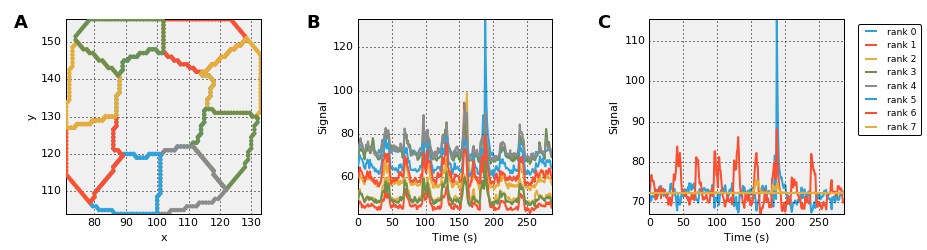

In [5]:
%%opts Curve {+axiswise} Overlay [legend_position='right']
# show the rois + extracted curves for a single tiff + cell
# pick trial tiff and cell:
tiff = 1
cell = 0

# plot
hv.Curve.kdims =   [hv.Dimension('Time (s)')]
hv.Curve.vdims = [hv.Dimension('Signal')]

fig_roi  = hv.Overlay()
fig_raw  = hv.Overlay()
fig_mat  = hv.Overlay()
for signal in range(1+nNpil):
    fig_roi *= hv.Scatter(S['ROIs'][cell][tiff][signal][0])
    fig_raw *= hv.Curve(S['Data'][cell][tiff][signal])

for signal in range(len(S['Mat'][cell][tiff])):
    fig_mat *= hv.Curve(S['Mat'][cell][tiff][signal],label='rank '+str(signal))
fig_roi + fig_raw + fig_mat

In [6]:
npil.NMF?